In [1]:
import pyart
import numpy as np
import matplotlib.pyplot as plt
from vcor_dual_prf import correct_dualprf
from scipy.ndimage import median_filter

In [2]:
radar = pyart.aux_io.read_gamic('217BRS-20221030173104.HDF5')

### CORRECTING THE CATASTROPHIC ERRORS IN RADIAL VELOCITY

You may have noticed that radial velocity has a lot of speckles known as catastrophic errors. This happens in areas of high azimutal shear and spectrum width when staggered PRTs are used to extend the Nyquist interval. This issue is further coumpounded by the high PRT ratio (4/5) implemented in this radar. Luckily, we can correct most of these errors using circular statistics adapting the algorithmos developed by Altube et al. (2017) and Hengstbeck et al. (2018) for radar's implementing the dual-PRF technique.

First, let's look at what sweeps the staggered PRT technique is applied to retrieve the radial velocity

In [3]:
radar.instrument_parameters['prt_mode']

{'comments': 'Pulsing mode Options are: "fixed", "staggered", "dual". Assumed "fixed" if missing.',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulsing mode',
 'units': 'unitless',
 'data': array(['staggered', 'staggered', 'staggered', 'staggered', 'staggered',
        'staggered', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed'],
       dtype='<U9')}

We can see that the staggered PRT is implemented in the six lowest sweeps. We need to change this to "dual" in order to the algorithm work

In [4]:
for n, prt_mode in enumerate(radar.instrument_parameters['prt_mode']['data']):
    if prt_mode =='staggered':
        radar.instrument_parameters['prt_mode']['data'][n] = b'dual'
    if prt_mode =='fixed':
        radar.instrument_parameters['prt_mode']['data'][n] = b'fixed'

radar.instrument_parameters['prt_mode']['data'] = radar.instrument_parameters['prt_mode']['data'].astype('|S5')

Let's check the prt mode again

In [7]:
radar.instrument_parameters['prt_mode']

{'comments': 'Pulsing mode Options are: "fixed", "staggered", "dual". Assumed "fixed" if missing.',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulsing mode',
 'units': 'unitless',
 'data': array([b'dual', b'dual', b'dual', b'dual', b'dual', b'dual', b'fixed',
        b'fixed', b'fixed', b'fixed', b'fixed'], dtype='|S5')}

Now, we need to invert the PRT ratio array as if it was a PRF one

In [8]:
radar.instrument_parameters['prt_ratio']['data'] = 1 / radar.instrument_parameters['prt_ratio']['data']

Let's check it now

In [10]:
radar.instrument_parameters['prt_ratio']

{'units': 'unitless',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulse repetition frequency ratio',
 'data': array([1.25, 1.25, 1.25, ..., 1.  , 1.  , 1.  ], dtype=float32)}

Lastly, we need to create a dummy PRF flag array that is usually present in dual-PRF radars. This array will alternate between short (0) and long (1) PRFs.

In [ ]:
radar.instrument_parameters['prf_flag'] = {'units': 'unitless',
                                           'comments': 'PRF used to collect ray. 0 for high PRF, 1 for low PRF.',
                                           'meta_group': 'instrument_parameters',
                                           'long_name': 'PRF flag',
                                           'data':np.resize(([0, 1]), radar.nrays)}

In [13]:
radar.instrument_parameters['prf_flag']

{'units': 'unitless',
 'comments': 'PRF used to collect ray. 0 for high PRF, 1 for low PRF.',
 'meta_group': 'instrument_parameters',
 'long_name': 'PRF flag',
 'data': array([0, 1, 0, ..., 1, 0, 1])}

With all changes necessary made, we know can run the alogorithms in order to correct the radial velocity field. 

There are two algorithms that work very well; Altube's et al. (2017) cmean_sc and median, and Hengstbeck' et al. (2018) cmean. 
Altube's algorithm tends to lead slightly better results but takes significantly longer time to run. Hengstbeck's tends bo faster and also result in significant results.

Here, let's make the correction using the Hengstbeck algorithm.

In [16]:
correct_dualprf(radar=radar, two_step=True,
                     method_det='cmean', kernel_det=np.ones((11, 11)),
                     method_cor='cmean', kernel_cor=np.ones((5, 5)),
                     vel_field='corrected_velocity', new_field='vcor_cmean', replace=True)

radar.fields['vcor_cmean']['units'] = 'meters_per_second'
radar.fields['vcor_cmean']['standard_name'] = 'corrected_radial_velocity_of_scatterers_away_from_instrument'
radar.fields['vcor_cmean']['long_name'] = 'Corrected mean doppler velocity'
radar.fields['vcor_cmean']['coordinates'] = 'elevation azimuth range'

The corrected radial velocity field was added as the vcor_cmean variable. Let's compare the before and after.

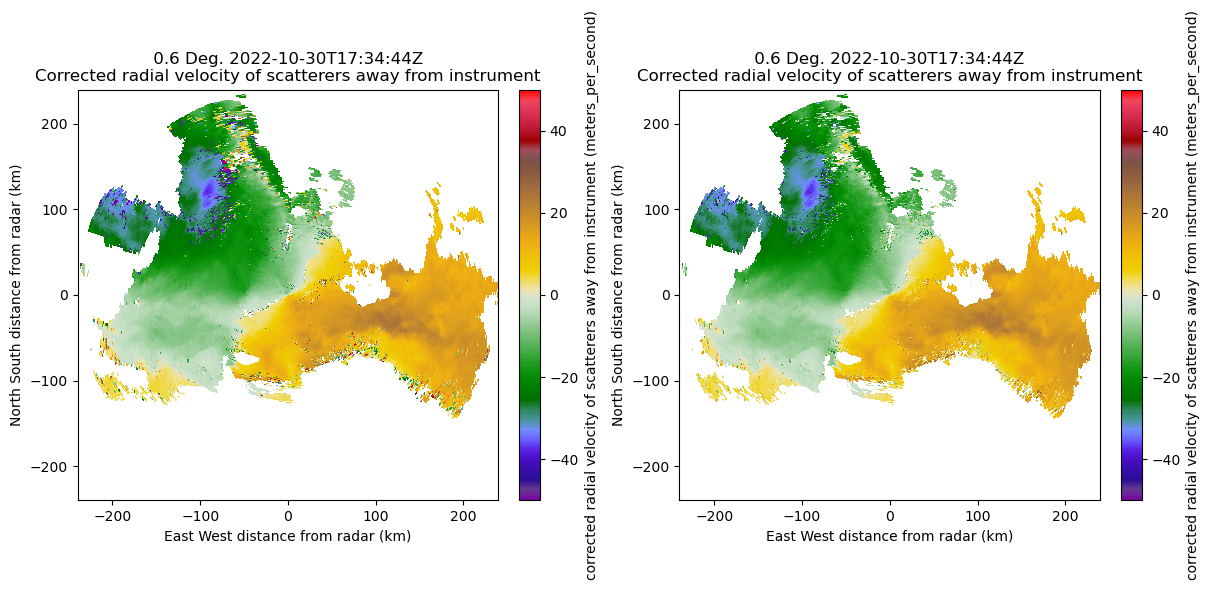

In [17]:
fig, axs = plt.subplots(1, 2, figsize = [12, 5], constrained_layout = True)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[0])
display.plot_ppi('vcor_cmean', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])

It's easy to see that there was a significant improvent compared with the original field. However, the algorithm can't correct adequately areas plagued by a large number of bad gates as it needs at least two good neighboring gates in order to perform the correction. Nevertheless, we can use a simple filter based on a 3x3 moving median filter to remove the remaining spackles. This will smooth the radial velocity field a little bit, but will get rid of these remaining speckles

In [18]:
vel_smooth = median_filter(radar.fields['vcor_cmean']['data'], 3)
smooth_data_ma = np.ma.masked_where(np.ma.getmask(radar.fields['vcor_cmean']['data']), vel_smooth)
smooth_data_ma = np.ma.masked_equal(smooth_data_ma, smooth_data_ma.min())
radar.add_field_like('vcor_cmean', 'vcor_cmean_smooth', 
                     smooth_data_ma, replace_existing = True)

The filtered vcor_cmean was added as the vcor_cmean_smooth variables. Let's check the results

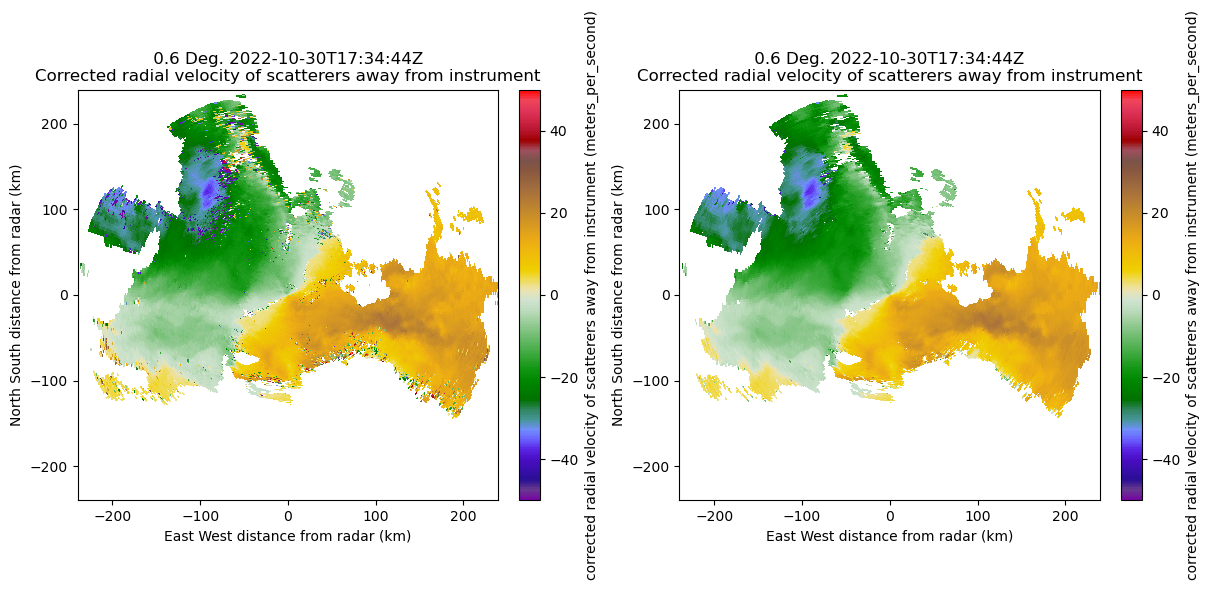

In [19]:
fig, axs = plt.subplots(1, 2, figsize = [12, 5], constrained_layout = True)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[0])
display.plot_ppi('vcor_cmean_smooth', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])

We can see that most of the bad gates were finally corrected. A small number o speckles still remain but these are negligible. 
Finally, we can compare the improvement over each step.

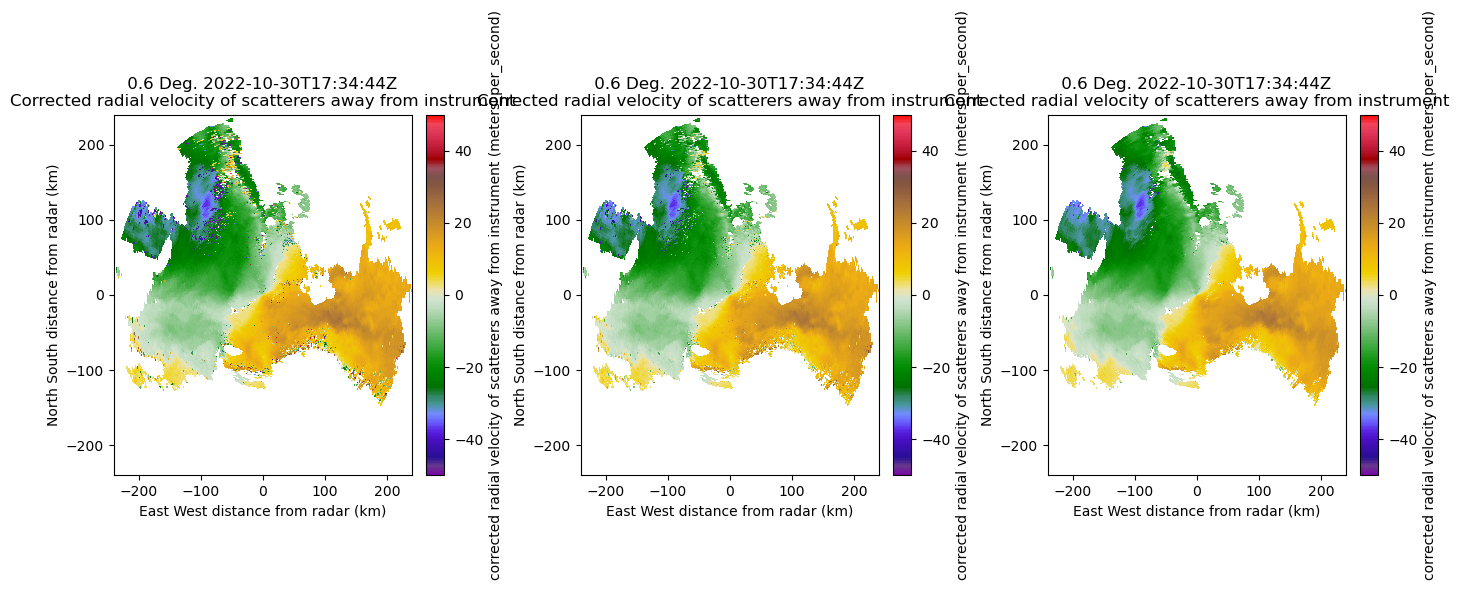

In [25]:
fig, axs = plt.subplots(1, 3, figsize = [14, 4.5], constrained_layout = True)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[0])
display.plot_ppi('vcor_cmean', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('vcor_cmean_smooth', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[2])